## Enable GPU and set up helper functions


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print('GPU found {}'.format(device_name))

2.12.0
GPU found /device:GPU:0


## Read Oxford-IIIT Pets dataset

The dataset is part of TensorFlow datasets.
Version 3 and higher of the dataset has ground truth
segmentation masks.

The dataset already contains test and train splits.

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteWOPA6O/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteWOPA6O/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def read_and_preprocess(data):
    input_img = tf.image.resize(data['image'], (128,128)) #resizing the image shape
    input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))  #resizing the mask shape

    input_img = tf.image.convert_image_dtype(input_img, tf.float32) #converting image to 0,1 form
    input_mask -=1 #from {1,2,3} to {0,1,2}
    return input_img , input_mask

In [ ]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls = tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

## Display some example images and their labels

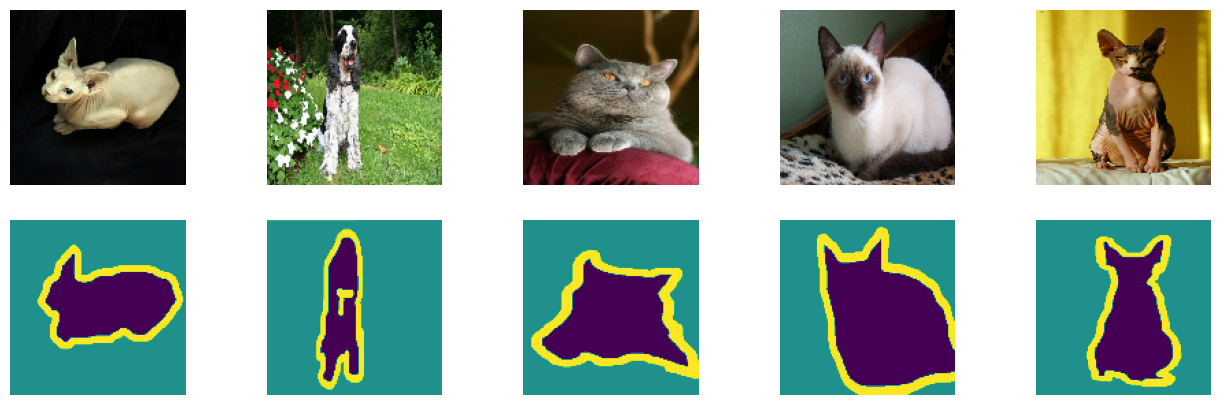

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
f, ax = plt.subplots(2, 5, figsize = (16,5))
for idx,(img, mask) in enumerate(train.take(5)):
    ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, idx].axis('off')
    mask = tf.reshape(mask, [128,128])
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis('off')

## Modified U-Net
The model being used here is a modified [U-Net](https://link.springer.com/content/pdf/10.1007%2F978-3-319-24574-4_28.pdf).
A U-Net typically consists of an encoder
which downsamples an image to an encoding,
and a mirrored decoder which upsamples the encoding
back to the desired mask. The decoder blocks have a number of skip connections
that directly connect the encoder blocks to the decoder.

Doing this from scratch requires a lot of trainable parameters

In this notebook, we will use a pretrained MobileNetV2 to
create the encoding and a set of upsampling layers to
get back to the desired mask.
When doing so, however, we will pull out layers with the
desired sizes so that the upsampling skip layers use
corresponding weights from the pretrained models.

To make the dataset go a little bit farther,
we also augment the training dataset to flip the images.

Note that the output consists of 3 channels. This is because we have 3 possible labels for each pixel (background, outline, interior). Think of this as multi-classification problem with three possible classes.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
def agument(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask

train_dataset = train.cache().map(agument).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

In [ ]:
TRAIN_LENGHT = info.splits['train'].num_examples
STEP_PER_EPOCHS = TRAIN_LENGHT // BATCH_SIZE
OUTPUT_CHANNLE = 3

### base model
 - we will use mobilenetv2 as a base model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = [128,128, 3], include_top = False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_output = [base_model.get_layer(name).output for name in layer_names]

# create feature extraction model
down_stack = tf.keras.Model(inputs = base_model.input, outputs = base_model_output,
                           name = 'pretrained_mobilenet')
down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


The decoder/upsampler is a series of upsample blocks.
Conv2DTranspose is what does the upsampling.
We also add batchnorm and relu.

In [ ]:

from tensorflow.keras import Sequential, layers

def upsample(filters, size, name):
    return Sequential([
        layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same'),
        layers.BatchNormalization(),
        layers.ReLU(),
    ], name = name)
up_stack = [
    upsample(512, 3, 'upsample_4x4_to_8x8'),
    upsample(256, 3, 'upsample_8x8_to_16x16'),
    upsample(128, 3, 'upsample_16x16_to_32x32'),
    upsample(64, 3,  'upsample_32x32_to_64x64')
]


In [ ]:
#u_t
import re
def u_net(output_channles):
    inputs = layers.Input(shape = [128, 128, 3], name = 'input_image')

    #dwon_sampling
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    #upsampling
    for idx, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        concat = layers.Concatenate(name= 'expand_{}'.format(idx))
        x = concat([x, skip])

    #last layer of model
    last = layers.Conv2DTranspose(output_channles, 3, strides = 2, padding = 'same')
    x = last(x)
    return tf.keras.Model(inputs = inputs, outputs = x)

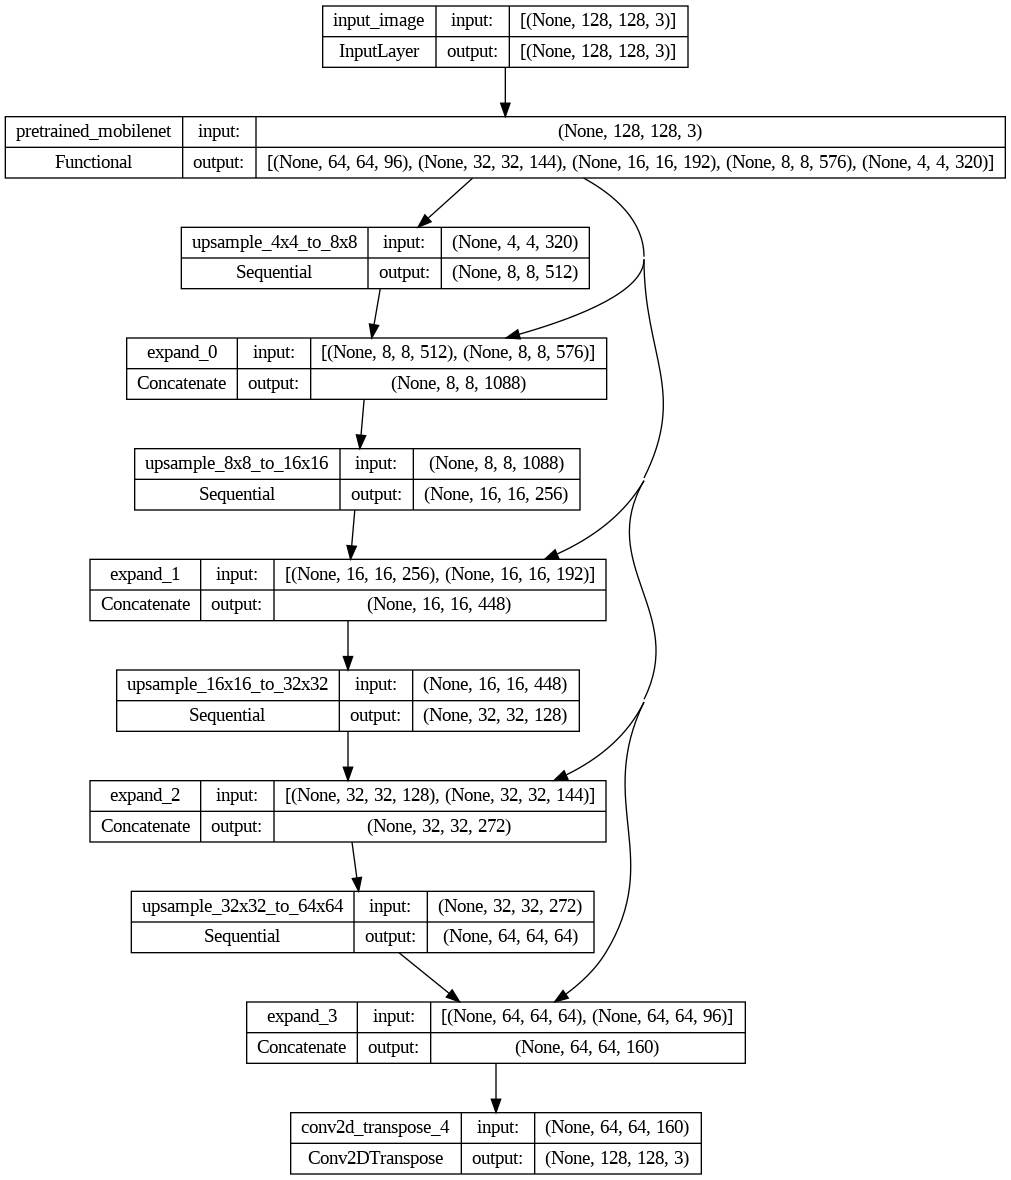

In [ ]:
model = u_net(OUTPUT_CHANNLE)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model = u_net(OUTPUT_CHANNLE)
model.compile( optimizer = 'adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =True), metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
# display helper functions
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

def show_predictions(dataset, num):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 10s 10s/step


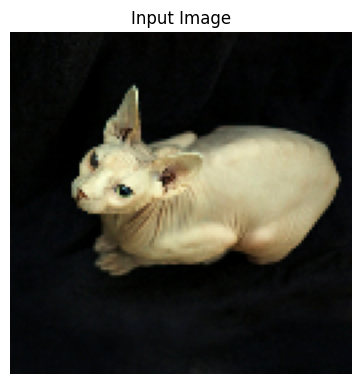

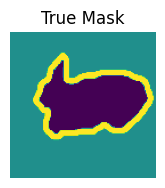

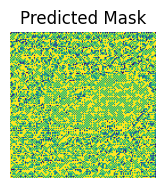

In [ ]:
show_predictions(train.batch(1), 1)

To observe how the model improves while it is training we define a callback function to show the predictions when the epoch finishes.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
            if epoch%5 == 0:
              # clear_output(wait=True) # if you want replace the images each time, uncomment this
              show_predictions(train.batch(1), 1)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 68ms/step


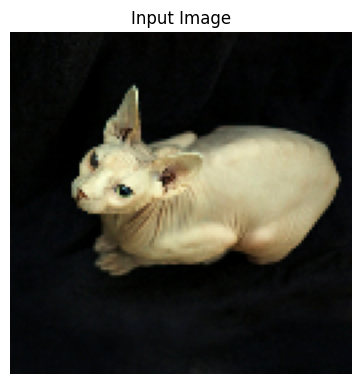

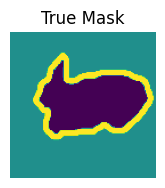

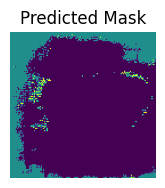


Sample Prediction after epoch 1

57/57 [==============================] - 442s 7s/step - loss: 0.7797 - accuracy: 0.6700 - val_loss: 1.8978 - val_accuracy: 0.4757


In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
model_history = model.fit(train_dataset,
                         steps_per_epoch = STEP_PER_EPOCHS,
                         validation_steps = VALIDATION_STEPS,
                         validation_data = test_dataset,
                         callbacks = [DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history['val_loss']
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss,'r', label = 'training loss')
plt.plot(epochs, val_loss, 'bo', label = 'validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()